# LS100: Joint Angles & Derived Metrics
This notebook takes **2D pose landmarks** produced by the previous notebook and computes **biomechanical joint angles** per frame. It also provides plotting utilities to visualize angle trajectories over time.

## Goal
**Compute biomechanical joint angles from pose landmark data.**  
You will define which angles to compute (e.g., left elbow, right knee) by specifying three landmarks `(A, B, C)` that form the angle at **B** (∠ABC).

### Imports and Environment Check (Code)

In [3]:
# In case you need to install any packages (like `plotly` or `seaborn`), uncomment and run the following line:
# %pip install plotly seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 13.8 MB/s  0:00:004.6 MB/s eta 0:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [plotly]━━━━ 1/2 [plotly]
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Imports & Environment Check
import sys, os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly as px

# Optional (requested) for nicer charts
try:
    import seaborn as sns  # noqa: F401
    _HAS_SEABORN = True
except Exception:
    _HAS_SEABORN = False

print("Python:", sys.version)
print("Pandas:", pd.__version__)
print("NumPy :", np.__version__)
print("Plotly:", px.__version__)
print("Seaborn available:", _HAS_SEABORN)


Python: 3.12.12 (main, Oct  9 2025, 11:07:00) [Clang 17.0.0 (clang-1700.3.19.1)]
Pandas: 2.3.3
NumPy : 1.26.4
Plotly: 6.3.1
Seaborn available: True


### Load 2D Pose CSV

In [2]:
# 5) Load 2D Pose CSV
# Set the path to your *_pose2d.csv (raw or *_filtered.csv) from Notebook 1.
pose2d_csv_path = r"/Users/ameliaxu/Documents/ls100_project/MediaPipeEnv/outputs/points2d/04_1_fast_pose2d.csv"  # ← replace as needed

df = pd.read_csv(pose2d_csv_path)
print("Loaded:", pose2d_csv_path, "shape:", df.shape)
print("Columns:", list(df.columns))
if "landmark_name" in df.columns:
    print("Landmark names:", df["landmark_name"].unique()[:40])
df.head(3)


Loaded: /Users/ameliaxu/Documents/ls100_project/MediaPipeEnv/outputs/points2d/04_1_fast_pose2d.csv shape: (255420, 9)
Columns: ['video', 'frame', 'time_ms', 'landmark_index', 'landmark_name', 'x', 'y', 'z', 'visibility']
Landmark names: ['nose' 'left_eye_inner' 'left_eye' 'left_eye_outer' 'right_eye_inner'
 'right_eye' 'right_eye_outer' 'left_ear' 'right_ear' 'mouth_left'
 'mouth_right' 'left_shoulder' 'right_shoulder' 'left_elbow' 'right_elbow'
 'left_wrist' 'right_wrist' 'left_pinky' 'right_pinky' 'left_index'
 'right_index' 'left_thumb' 'right_thumb' 'left_hip' 'right_hip'
 'left_knee' 'right_knee' 'left_ankle' 'right_ankle' 'left_heel'
 'right_heel' 'left_foot_index' 'right_foot_index']


video  frame  time_ms  landmark_index   landmark_name         x  \
0  04_1_fast.mp4      0        0               0            nose  0.408373   
1  04_1_fast.mp4      0        0               1  left_eye_inner  0.411214   
2  04_1_fast.mp4      0        0               2        left_eye  0.414962   

          y         z  visibility  
0  0.190263 -0.193396         1.0  
1  0.171291 -0.161437         1.0  
2  0.173330 -0.161718         1.0

## Define Custom Angles
Provide a list of angle definitions. Each item defines the angle at **B** formed by points **A–B–C**.

**Example:**
```python
angle_defs = [
    {"name": "left_elbow",  "A": "left_shoulder", "B": "left_elbow", "C": "left_wrist"},
    {"name": "right_knee",  "A": "right_hip",     "B": "right_knee", "C": "right_ankle"},
]


In [3]:

# Edit this list for your work:
angle_defs = [
    {"name": "right_body",  "A": "right_shoulder", "B": "right_hip", "C": "horizontal"},
    {"name": "right_elbow", "A": "right_shoulder", "B": "right_elbow","C": "right_wrist"},
    {"name": "right_knee",   "A": "right_hip", "B": "right_knee",  "C": "right_ankle"},
    {"name": "right_hip",  "A": "right_shoulder", "B": "right_hip", "C": "right_knee"}
]

relative_pos = [
    {"A": "right_index", "B": "right_knee", "name": "hand_knee"}
]
print(angle_defs)
print(relative_pos)

[{'name': 'right_body', 'A': 'right_shoulder', 'B': 'right_hip', 'C': 'horizontal'}, {'name': 'right_elbow', 'A': 'right_shoulder', 'B': 'right_elbow', 'C': 'right_wrist'}, {'name': 'right_knee', 'A': 'right_hip', 'B': 'right_knee', 'C': 'right_ankle'}, {'name': 'right_hip', 'A': 'right_shoulder', 'B': 'right_hip', 'C': 'right_knee'}]
[{'A': 'right_index', 'B': 'right_knee', 'name': 'hand_knee'}]


### Computation Angles and Relative Positions

#### Angle & Relative Position Computation Function

* The following function calculates the angles and the relative x-position you defined.
* Please change the `visibility_thresh` according to your desire. This will determine the 'confidence' in each angle in each frame.

"good" → all three landmarks ≥ threshold  
"low" → exactly one landmark < threshold  
"least" → two or three landmarks < threshold


In [4]:
# User threshold for angle confidence (edit if desired)
visibility_thresh = 0.5  # used only for confidence labels here

def _wide_xyv(df2d: pd.DataFrame) -> pd.DataFrame:
    """
    Pivot to wide format with index (video, frame, time_ms) and columns:
      x_<landmark>, y_<landmark>, v_<landmark>
    If 'visibility' is missing, v_<landmark> defaults to 1.0 (assume good).
    """
    w_x = df2d.pivot_table(index=["video","frame","time_ms"], columns="landmark_name", values="x")
    w_y = df2d.pivot_table(index=["video","frame","time_ms"], columns="landmark_name", values="y")
    if "visibility" in df2d.columns:
        w_v = df2d.pivot_table(index=["video","frame","time_ms"], columns="landmark_name", values="visibility").fillna(0.0)
    else:
        w_v = pd.DataFrame(1.0, index=w_x.index, columns=w_x.columns)

    w_x.columns = [f"x_{c}" for c in w_x.columns]
    w_y.columns = [f"y_{c}" for c in w_y.columns]
    w_v.columns = [f"v_{c}" for c in w_v.columns]

    w = pd.concat([w_x, w_y, w_v], axis=1).sort_index()
    return w

def _angle_at_B(A_pts: np.ndarray, B_pts: np.ndarray, C_pts: np.ndarray) -> np.ndarray:
    """
    Compute angle at B for triplets (A, B, C) for all rows.
    Expects arrays [N,2]. Returns degrees in [0,180].
    """
    BA = A_pts - B_pts
    BC = C_pts - B_pts
    denom = (np.linalg.norm(BA, axis=1) * np.linalg.norm(BC, axis=1)) + 1e-9
    cosang = (BA * BC).sum(1) / denom
    cosang = np.clip(cosang, -1.0, 1.0)
    return np.degrees(np.arccos(cosang))

def compute_angles(df2d: pd.DataFrame, defs: list, visibility_thresh: float = 0.5) -> pd.DataFrame:
    """
    Returns a DataFrame with (video, frame, time_ms) + per-angle columns:
      angle_<name>           (float degrees)
      confidence_<name>      ('good' | 'low' | 'least')

    Confidence rule per frame for a given angle:
      - 'good'  : all A/B/C vis >= threshold
      - 'low'   : exactly one of A/B/C vis < threshold
      - 'least' : two or three of A/B/C vis < threshold
    """
    w = _wide_xyv(df2d)
    out = pd.DataFrame(index=w.index)

    for d in defs:
        A, B, C = d["A"], d["B"], d["C"]
        name = d["name"]

        # 特殊处理 right_body：用水平线替代 C 点
        if name == "right_body" and C == "horizontal":
            A_pts = np.c_[w[f"x_{A}"].values, w[f"y_{A}"].values]
            B_pts = np.c_[w[f"x_{B}"].values, w[f"y_{B}"].values]
            # 构造一个点 C，与 B 同 y，但 x 比 B 大一点
            C_pts = np.c_[w[f"x_{B}"].values + 1.0, w[f"y_{B}"].values]
        else:
            cols_needed = [f"x_{A}", f"y_{A}", f"x_{B}", f"y_{B}", f"x_{C}", f"y_{C}",
                           f"v_{A}", f"v_{B}", f"v_{C}"]
            missing = [c for c in cols_needed if c not in w.columns]
            if missing:
                print(f"Warning: missing columns for angle '{name}': {missing}. Skipping.")
                continue

            A_pts = np.c_[w[f"x_{A}"].values, w[f"y_{A}"].values]
            B_pts = np.c_[w[f"x_{B}"].values, w[f"y_{B}"].values]
            C_pts = np.c_[w[f"x_{C}"].values, w[f"y_{C}"].values]

        # --- 角度计算 ---
        ang = _angle_at_B(A_pts, B_pts, C_pts)

        # --- 置信度 ---
        if name == "right_body" and C == "horizontal":
            vA = w[f"v_{A}"].fillna(0.0).values
            vB = w[f"v_{B}"].fillna(0.0).values
            below = (vA < visibility_thresh).astype(int) + (vB < visibility_thresh).astype(int)
        else:
            vA = w[f"v_{A}"].fillna(0.0).values
            vB = w[f"v_{B}"].fillna(0.0).values
            vC = w[f"v_{C}"].fillna(0.0).values
            below = (vA < visibility_thresh).astype(int) + (vB < visibility_thresh).astype(int) + (vC < visibility_thresh).astype(int)

        conf = np.where(below == 0, "good", np.where(below == 1, "low", "least"))

        out[f"angle_{name}"] = ang
        out[f"confidence_{name}"] = conf

    return out.reset_index()

def compute_relative_xpos(df2d: pd.DataFrame, pairs: list, visibility_thresh: float = 0.5) -> pd.DataFrame:
    """
    Compute relative x-position (A.x - B.x) for given landmark pairs.

    Returns DataFrame with:
      video, frame, time_ms,
      relx_<name>              (float)
      confidence_<name>        ('good' | 'low' | 'least')

    Confidence rule per frame for a given pair:
      - 'good'  : both A and B vis >= threshold
      - 'low'   : exactly one of A/B vis < threshold
      - 'least' : both A/B vis < threshold
    """
    w = _wide_xyv(df2d)
    out = pd.DataFrame(index=w.index)

    for p in pairs:
        A, B, name = p["A"], p["B"], p["name"]
        cols_needed = [f"x_{A}", f"x_{B}", f"v_{A}", f"v_{B}"]
        missing = [c for c in cols_needed if c not in w.columns]
        if missing:
            print(f"Warning: missing columns for pair '{name}': {missing}. Skipping.")
            continue

        # compute relative x position
        relx = w[f"x_{A}"].values - w[f"x_{B}"].values

        # confidence
        vA = w[f"v_{A}"].fillna(0.0).values
        vB = w[f"v_{B}"].fillna(0.0).values
        below = (vA < visibility_thresh).astype(int) + (vB < visibility_thresh).astype(int)
        conf = np.where(below == 0, "good", np.where(below == 1, "low", "least"))

        # assign columns
        out[f"relx_{name}"] = relx
        out[f"confidence_{name}"] = conf

    return out.reset_index()


#### 6.b Core logic to compute ∠ABC

In [5]:
angles_df = compute_angles(df, angle_defs, visibility_thresh=visibility_thresh)
print("Angles shape:", angles_df.shape)
print(angles_df.head())

df_relx = compute_relative_xpos(df, relative_pos, visibility_thresh=0.5)
print("pos shape:", df_relx.shape)
print(df_relx.head())

Angles shape: (7740, 11)
           video  frame  time_ms  angle_right_body confidence_right_body  \
0  04_1_fast.mp4      0        0         93.782043                  good   
1  04_1_fast.mp4      1        8         93.783824                  good   
2  04_1_fast.mp4      2       16         93.792461                  good   
3  04_1_fast.mp4      3       25         93.917691                  good   
4  04_1_fast.mp4      4       33         94.062634                  good   

   angle_right_elbow confidence_right_elbow  angle_right_knee  \
0         149.236156                   good         79.132490   
1         148.809575                   good         78.327349   
2         148.624466                   good         78.057758   
3         148.184286                   good         78.173406   
4         147.170290                   good         78.245920   

  confidence_right_knee  angle_right_hip confidence_right_hip  
0                  good        66.051740                 good  

### Save and Inspect Output

In [6]:
# merge angles_df & df_relx
merged_df = pd.merge(
    angles_df, df_relx,
    on=["video", "frame", "time_ms"], 
    how="outer"                        
)

# save the merged file
pose2d_csv = Path(pose2d_csv_path)
out_dir = pose2d_csv.parent
merged_out = out_dir / f"{pose2d_csv.stem}_angles_relx.csv"
merged_df.to_csv(merged_out, index=False)

print("✅ Saved merged angles + relative positions to:", merged_out)
merged_df.head()


✅ Saved merged angles + relative positions to: /Users/ameliaxu/Documents/ls100_project/MediaPipeEnv/outputs/points2d/04_1_fast_pose2d_angles_relx.csv


video  frame  time_ms  angle_right_body confidence_right_body  \
0  04_1_fast.mp4      0        0         93.782043                  good   
1  04_1_fast.mp4      1        8         93.783824                  good   
2  04_1_fast.mp4      2       16         93.792461                  good   
3  04_1_fast.mp4      3       25         93.917691                  good   
4  04_1_fast.mp4      4       33         94.062634                  good   

   angle_right_elbow confidence_right_elbow  angle_right_knee  \
0         149.236156                   good         79.132490   
1         148.809575                   good         78.327349   
2         148.624466                   good         78.057758   
3         148.184286                   good         78.173406   
4         147.170290                   good         78.245920   

  confidence_right_knee  angle_right_hip confidence_right_hip  relx_hand_knee  \
0                  good        66.051740                 good        0.022688   
1                  good        65.304049                 good        0.023070   
2                  good        65.011089                 good        0.023536   
3                  good        65.103589                 good        0.023296   
4                  good        65.179717                 good        0.022718   

  confidence_hand_knee  
0                 good  
1                 good  
2                 good  
3                 good  
4                 good

### Plotting the computed angles over time (matplotlib AND seaborn)

## 8) Plot Angles with Confidence Highlights

In this section, we visualize the computed joint angles for each frame.  
You can choose between **Matplotlib**, **Seaborn**, or **Plotly** for plotting:

- **Matplotlib** → simple, fast static plots.  
- **Seaborn** → adds smoothing and styling for a cleaner look.  
- **Plotly** → fully interactive charts with zoom, hover, and export options.

Each plot corresponds to one computed angle (e.g., `angle_left_knee`, `angle_right_elbow`, etc.).  
Colored transparent vertical patches mark frames with lower landmark visibility confidence:

- 🟡 **Yellow** → “low” confidence (one landmark below threshold)  
- 🟠 **Orange** → “least” confidence (two or three landmarks below threshold)

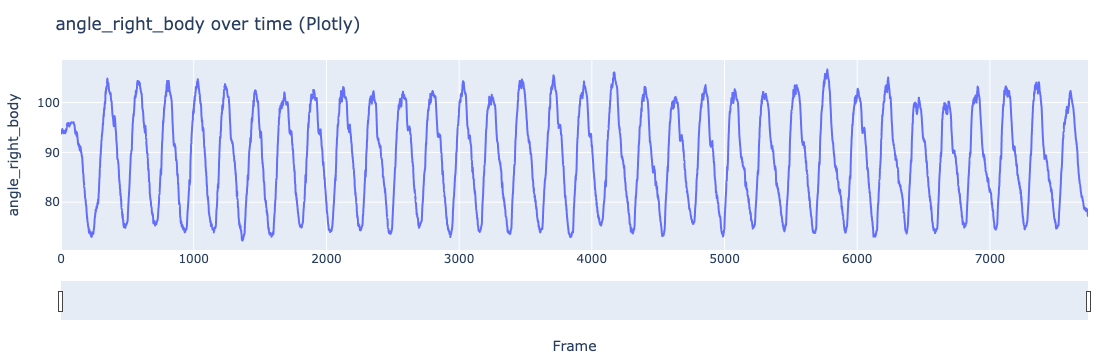

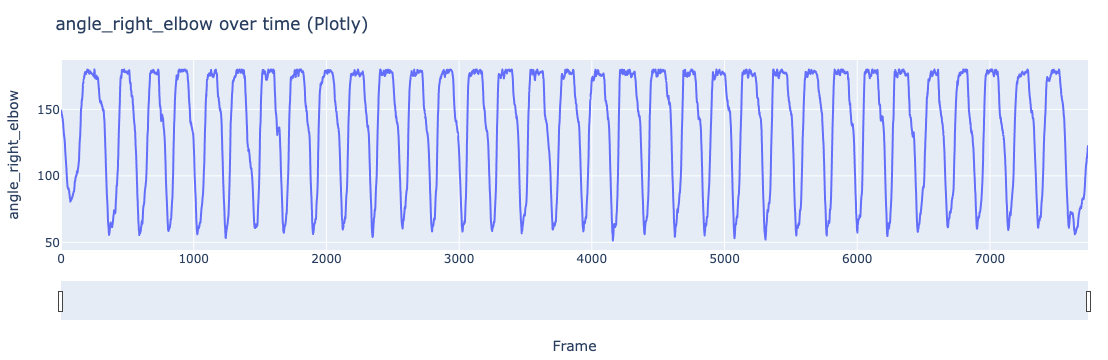

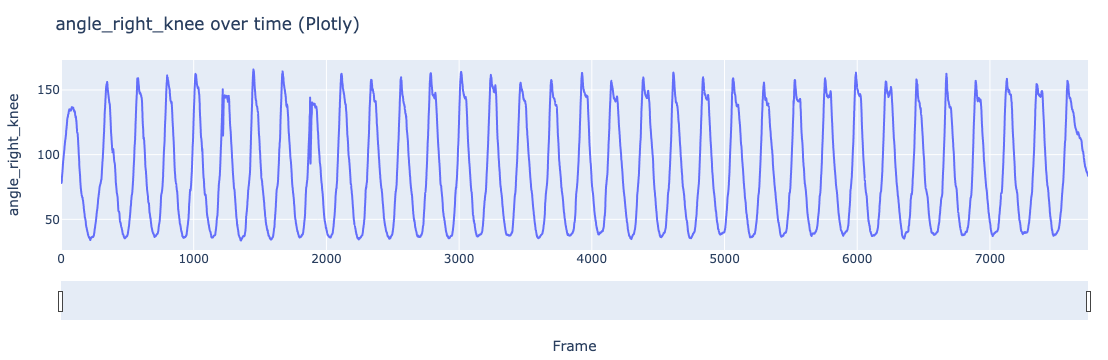

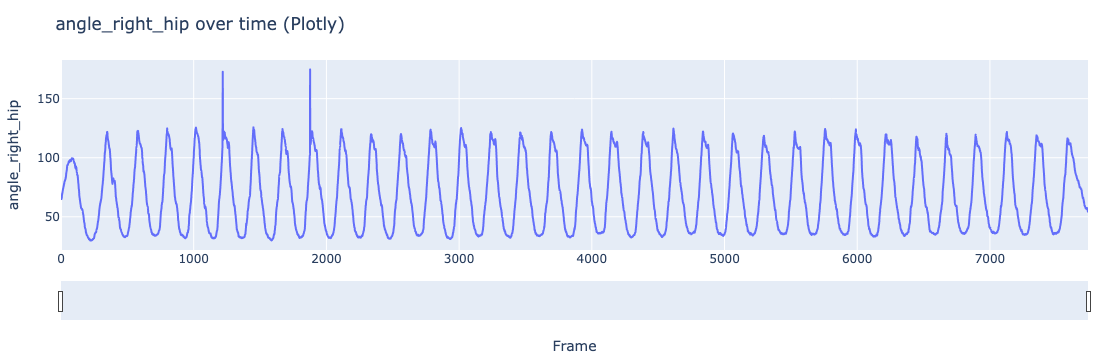

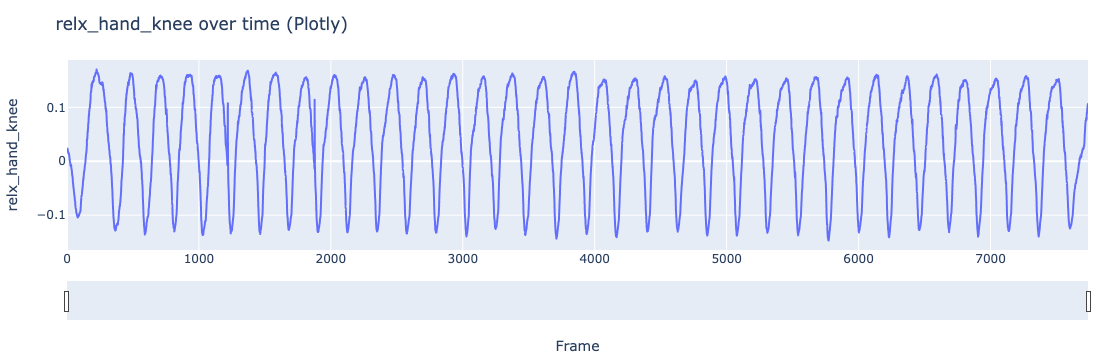

In [7]:
# ======================================================
# 8) Plotting the computed angles & relative positions
#    with confidence patches ("low" = yellow, "least" = orange)
# ======================================================

# --- User choices ---
plot_backend   = "plotly"   # "matplotlib" | "seaborn" | "plotly"
selected_video = None       # or a specific video filename

# --- Prep & validation ---
if "angles_df" not in globals():
    raise RuntimeError("angles_df not found. Run computations first.")
if "df_relx" not in globals():
    raise RuntimeError("df_relx not found. Compute relative positions first.")

# merge if not already done
df_plot = pd.merge(angles_df, df_relx, on=["video", "frame", "time_ms"], how="outer")

# optional filtering
if selected_video is not None:
    df_plot = df_plot[df_plot["video"] == selected_video]
    if df_plot.empty:
        raise ValueError(f"No rows found for video '{selected_video}'.")

title_suffix = f" — {selected_video}" if selected_video else ""
backend = plot_backend.strip().lower()

# helper for shading
def _spans_from_labels(frame_series, label_series, label_value):
    frames = frame_series.to_numpy()
    labels = (label_series.to_numpy() == label_value)
    spans = []
    start = None
    last_frame = None
    for f, ok in zip(frames, labels):
        if ok and start is None:
            start = f
        if ok:
            last_frame = f
        if (not ok) and (start is not None):
            spans.append((start, last_frame))
            start = None
    if start is not None:
        spans.append((start, last_frame))
    return spans

# find columns
angle_cols = [c for c in df_plot.columns if c.startswith("angle_")]
relx_cols  = [c for c in df_plot.columns if c.startswith("relx_")]

# ---------------- BACKEND-SPECIFIC PLOTS ----------------
if backend == "matplotlib":
    import matplotlib.pyplot as plt

    for col in angle_cols + relx_cols:
        conf_col = "confidence_" + col.split("_", 1)[1]
        plt.figure(figsize=(10, 4))
        plt.plot(df_plot["frame"], df_plot[col])
        plt.xlabel("Frame")
        plt.ylabel(col)
        plt.title(f"{col} over time (matplotlib){title_suffix}")
        ax = plt.gca()

        if conf_col in df_plot.columns:
            for x0, x1 in _spans_from_labels(df_plot["frame"], df_plot[conf_col], "low"):
                ax.axvspan(x0, x1, color="yellow", alpha=0.25, linewidth=0)
            for x0, x1 in _spans_from_labels(df_plot["frame"], df_plot[conf_col], "least"):
                ax.axvspan(x0, x1, color="orange", alpha=0.25, linewidth=0)

        plt.tight_layout()
        plt.show()

elif backend == "seaborn":
    import seaborn as sns
    import matplotlib.pyplot as plt

    for col in angle_cols + relx_cols:
        conf_col = "confidence_" + col.split("_", 1)[1]
        plt.figure(figsize=(10, 4))
        sns.lineplot(data=df_plot, x="frame", y=col)
        plt.xlabel("Frame")
        plt.ylabel(col)
        plt.title(f"{col} over time (seaborn){title_suffix}")
        ax = plt.gca()

        if conf_col in df_plot.columns:
            for x0, x1 in _spans_from_labels(df_plot["frame"], df_plot[conf_col], "low"):
                ax.axvspan(x0, x1, color="yellow", alpha=0.25, linewidth=0)
            for x0, x1 in _spans_from_labels(df_plot["frame"], df_plot[conf_col], "least"):
                ax.axvspan(x0, x1, color="orange", alpha=0.25, linewidth=0)

        plt.tight_layout()
        plt.show()

elif backend == "plotly":
    import plotly.express as px

    for col in angle_cols + relx_cols:
        conf_col = "confidence_" + col.split("_", 1)[1]
        fig = px.line(
            df_plot,
            x="frame",
            y=col,
            title=f"{col} over time (Plotly){title_suffix}",
            labels={"frame": "Frame", col: col}
        )

        # confidence shading
        if conf_col in df_plot.columns:
            for x0, x1 in _spans_from_labels(df_plot["frame"], df_plot[conf_col], "low"):
                fig.add_vrect(x0=x0, x1=x1, fillcolor="yellow", opacity=0.25, line_width=0)
            for x0, x1 in _spans_from_labels(df_plot["frame"], df_plot[conf_col], "least"):
                fig.add_vrect(x0=x0, x1=x1, fillcolor="orange", opacity=0.25, line_width=0)

        fig.update_layout(
            xaxis_rangeslider_visible=True,
            hovermode="x unified",
            margin=dict(l=40, r=20, t=60, b=40)
        )
        fig.show()

else:
    raise ValueError("Unknown plot_backend. Choose 'matplotlib', 'seaborn', or 'plotly'.")

## Batch Angle Computation for a Folder of `*_pose2d.csv` Files

This section processes **all** 2D landmark CSVs in a directory and computes the defined joint angles for each file.

**How it works**
- You provide a directory path that contains files named like: `*_pose2d.csv`.
- For **each** file, we compute angles using your `angle_defs` and `visibility_thresh`.
- We save a per-file output next to the input as: `*_pose2d_angles.csv`.
- We also write a **batch manifest** CSV in the same directory summarizing the results and any errors.

> Tip: you can point this to a directory of filtered outputs as well (e.g., `*_pose2d_filtered.csv`) by adjusting the `pattern`.


In [8]:
# ======================================================
# 9) Batch run on a directory of *_pose2d.csv files
#     - Computes angles for each file using current angle_defs
#     - Saves <stem>_angles.csv next to each input
#     - Writes a batch manifest in the directory
# ======================================================

from pathlib import Path
import time, traceback

# --- Student input: paste the directory containing *_pose2d.csv files
pose2d_dir = r"/Users/ameliaxu/Documents/ls100_project/MediaPipeEnv/outputs/points2d"  # e.g., "/path/to/outputs"

# --- Optional: pattern tweak (default matches exactly *_pose2d.csv)
pattern = "*_pose2d.csv"   # change to "*_pose2d_filtered.csv" if you want filtered inputs

# --- Basic checks
if not pose2d_dir or not str(pose2d_dir).strip():
    raise ValueError("Please set pose2d_dir to a valid directory path.")
pose2d_dir = Path(pose2d_dir).expanduser().resolve()
if not pose2d_dir.exists() or not pose2d_dir.is_dir():
    raise NotADirectoryError(f"Not a directory: {pose2d_dir}")

# --- Verify dependencies from prior cells
required_globals = ["angle_defs", "compute_angles", "visibility_thresh"]
missing = [g for g in required_globals if g not in globals()]
if missing:
    raise RuntimeError(f"Missing prior definitions: {missing}. "
                       "Run the earlier cells (angle defs & compute_angles function).")

# --- Discover files
files = sorted(pose2d_dir.glob(pattern))
if not files:
    raise FileNotFoundError(f"No files matching pattern '{pattern}' in {pose2d_dir}")

print(f"Found {len(files)} file(s) in {pose2d_dir} matching '{pattern}'.")

# --- Process each file
records = []
t_batch0 = time.time()

for i, fpath in enumerate(files, 1):
    row = {
        "input_csv": str(fpath),
        "output_csv": None,
        "status": "ok",
        "error": "",
        "n_rows_in": None,
        "n_rows_out": None,
        "elapsed_s": None,
    }
    print(f"[{i}/{len(files)}] {fpath.name}")
    try:
        t0 = time.time()
        df_in = pd.read_csv(fpath)
        row["n_rows_in"] = len(df_in)

        # Compute angles using the same logic/thresholds as single-file mode
        angles_df = compute_angles(df_in, angle_defs, visibility_thresh=visibility_thresh)
        # --- Compute relative x-positions
        df_relx = compute_relative_xpos(df_in, relative_pos, visibility_thresh=visibility_thresh)

        # --- Merge both outputs
        merged_df = pd.merge(angles_df, df_relx, on=["video", "frame", "time_ms"], how="outer")

        # --- Save
        out_csv = fpath.with_name(f"{fpath.stem}_angles_relx.csv")
        merged_df.to_csv(out_csv, index=False)

        row["output_csv"] = str(out_csv)
        row["n_rows_out"] = len(merged_df)
        row["elapsed_s"] = round(time.time() - t0, 2)
        print(f"   → Saved: {out_csv.name}  ({row['n_rows_out']} rows, {row['elapsed_s']}s)")

    except Exception as e:
        row["status"] = "error"
        row["error"] = f"{e.__class__.__name__}: {e}"
        tb = traceback.format_exc().splitlines()[-3:]
        print("   ! Error:", row["error"])
        print("   ! Traceback (last lines):", "; ".join(tb))

    records.append(row)
    

# --- Write batch manifest
manifest = pose2d_dir / "batch_angles_relx_manifest.csv"
pd.DataFrame.from_records(records).to_csv(manifest, index=False)
print(f"\n✔ Batch complete. Manifest saved to: {manifest}")
print(f"Total elapsed: {time.time() - t_batch0:.1f}s")


Found 25 file(s) in /Users/ameliaxu/Documents/ls100_project/MediaPipeEnv/outputs/points2d matching '*_pose2d.csv'.
[1/25] 01_1_fast_pose2d.csv
   → Saved: 01_1_fast_pose2d_angles_relx.csv  (8520 rows, 0.36s)
[2/25] 01_1_low_pose2d.csv
   → Saved: 01_1_low_pose2d_angles_relx.csv  (10819 rows, 0.42s)
[3/25] 01_2_low_pose2d.csv
   → Saved: 01_2_low_pose2d_angles_relx.csv  (15120 rows, 0.58s)
[4/25] 01_4_low_pose2d.csv
   → Saved: 01_4_low_pose2d_angles_relx.csv  (31378 rows, 1.28s)
[5/25] 02_1_fast_pose2d.csv
   → Saved: 02_1_fast_pose2d_angles_relx.csv  (6420 rows, 0.26s)
[6/25] 02_1_low_pose2d.csv
   → Saved: 02_1_low_pose2d_angles_relx.csv  (9660 rows, 0.37s)
[7/25] 02_2_low_pose2d.csv
   → Saved: 02_2_low_pose2d_angles_relx.csv  (19080 rows, 0.74s)
[8/25] 02_4_low_pose2d.csv
   → Saved: 02_4_low_pose2d_angles_relx.csv  (29760 rows, 1.18s)
[9/25] 03_1_fast_pose2d.csv
   → Saved: 03_1_fast_pose2d_angles_relx.csv  (8220 rows, 0.33s)
[10/25] 03_1_low_pose2d.csv
   → Saved: 03_1_low_pose2d

# Data Filtering
## Starting Point Definition
Detect all the peaks of knee angle.
When the 10th peak is detected, count back 9 peaks as the starting point of rowing.

Detected 31 peaks. Start frame = 904 (10-stroke rule)
✅ Trimmed 7193 rows for 60s window and saved to:
/Users/ameliaxu/Documents/ls100_project/MediaPipeEnv/outputs/angle_relx_raw/1_fast/cleaned/05_1_fast_pose2d_angles_relx_cleaned_60s.csv


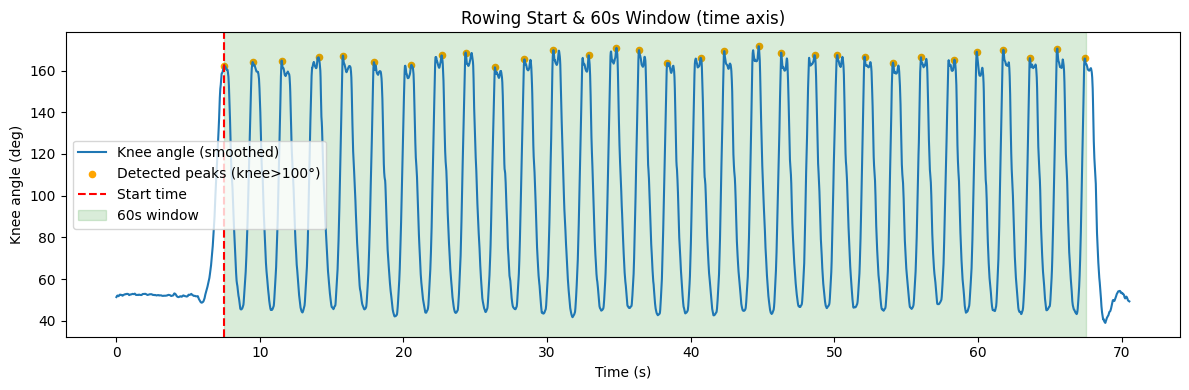

In [2]:
# ================================================
# Define rowing start point based on 10-stroke rule
# Trim EXACT 60s by time_ms and save
# ================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# === Config ===
FILE = Path(r"/Users/ameliaxu/Documents/ls100_project/MediaPipeEnv/outputs/angle_relx_raw/1_fast/05_1_fast_pose2d_angles_relx.csv")
OUT_DIR = FILE.parent / "cleaned"
OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT = OUT_DIR / f"{FILE.stem}_cleaned_60s.csv"

# ---------- Load data ----------
df = pd.read_csv(FILE)

# sort safely (prefer frame, else time)
if "frame" in df.columns:
    sort_keys = ["video", "frame"] if "video" in df.columns else ["frame"]
    df = df.sort_values(sort_keys).reset_index(drop=True)
elif "time_ms" in df.columns:
    sort_keys = ["video", "time_ms"] if "video" in df.columns else ["time_ms"]
    df = df.sort_values(sort_keys).reset_index(drop=True)

if "angle_right_knee" not in df.columns:
    raise ValueError("❌ Column 'angle_right_knee' not found in the CSV file!")
if "time_ms" not in df.columns:
    raise ValueError("❌ time_ms column not found — cannot trim by time.")

# ---------- Signal: knee angle ----------
signal = pd.to_numeric(df["angle_right_knee"], errors="coerce").interpolate()
signal = signal.rolling(window=5, center=True).mean()  # smooth

# === Improved peak detection with angle threshold ===
def find_peaks(y, min_dist, merge_window=100, angle_thresh=100):
    """
    1) Find local maxima 2) Within each merge_window, keep only the highest peak；
    3) Apply min_dist；4) Keep only peaks where y[p] > angle_thresh
    """
    y = np.asarray(y, dtype=float)
    if len(y) < 5:
        return np.array([], dtype=int)

    dy = np.diff(y)
    sign = np.sign(dy); sign[sign == 0] = 1
    raw_peaks = (np.diff(sign) < 0).nonzero()[0] + 1
    if len(raw_peaks) == 0:
        return np.array([], dtype=int)

    # Merge nearby peaks
    raw_peaks = raw_peaks[np.argsort(-y[raw_peaks])]
    keep = np.ones(len(raw_peaks), dtype=bool)
    for i in range(len(raw_peaks)):
        if not keep[i]:
            continue
        too_close = np.where(np.abs(raw_peaks - raw_peaks[i]) < merge_window)[0]
        too_close = too_close[too_close > i]
        keep[too_close] = False
    merged_peaks = np.sort(raw_peaks[keep])

    # min_dist + angle_thresh
    final = []
    last = -10**9
    for p in merged_peaks:
        if p - last >= min_dist and y[p] > angle_thresh:
            final.append(p)
            last = p
    return np.array(final, dtype=int)

# === Detect peaks ===
peaks = find_peaks(signal.values, min_dist=150, merge_window=100, angle_thresh=100)

# === Determine start by 10-stroke rule ===
if len(peaks) < 20:
    print(f"⚠️ Only {len(peaks)} peaks detected — using first peak as start.")
    start_frame = int(peaks[0]) if len(peaks) else 0
else:
    idx10 = 9  # index of the 10th peak
    idx_start = max(0, idx10 - 10)
    start_frame = int(peaks[idx_start])
    print(f"Detected {len(peaks)} peaks. Start frame = {start_frame} (10-stroke rule)")

# === Trim EXACT 1 min by time_ms ===
start_time = float(df.loc[start_frame, "time_ms"])
end_time = start_time + 60_000.0  # 60s

if "video" in df.columns:
    vid = df.loc[start_frame, "video"]
    mask = (df["video"] == vid) & (df["time_ms"] >= start_time) & (df["time_ms"] <= end_time)
else:
    mask = (df["time_ms"] >= start_time) & (df["time_ms"] <= end_time)

df_trim = df.loc[mask].reset_index(drop=True)

# === Assign stroke_id based on knee peaks ===
# Only keep peaks within the 60s window
peaks_in_window = [p for p in peaks if start_frame <= p < len(df) and 
                   df.loc[p, "time_ms"] >= start_time and df.loc[p, "time_ms"] <= end_time]

stroke_id = np.zeros(len(df_trim), dtype=int)
for i, p in enumerate(peaks_in_window):
    # define stroke segment from this peak to next peak (or to end)
    start_i = df_trim.index[df_trim["time_ms"] >= df.loc[p, "time_ms"]][0]
    end_time_next = df.loc[peaks_in_window[i + 1], "time_ms"] if i + 1 < len(peaks_in_window) else end_time
    end_i = df_trim.index[df_trim["time_ms"] <= end_time_next][-1]
    stroke_id[start_i:end_i + 1] = i + 1  # strokes start from 1

df_trim["stroke_id"] = stroke_id

# === Save cleaned data ===
df_trim.to_csv(OUT, index=False)
print(f"✅ Trimmed {len(df_trim)} rows for 60s window and saved to:\n{OUT.resolve()}")

# === Plot (time axis in seconds) ===
x_time = df["time_ms"].to_numpy() / 1000.0
plt.figure(figsize=(12, 4))
plt.plot(x_time, signal, label="Knee angle (smoothed)")
plt.scatter(x_time[peaks], signal.iloc[peaks], s=20, color="orange", label="Detected peaks (knee>100°)")
plt.axvline(start_time/1000.0, color="r", linestyle="--", label="Start time")
plt.axvspan(start_time/1000.0, end_time/1000.0, color="green", alpha=0.15, label="60s window")
plt.title("Rowing Start & 60s Window (time axis)")
plt.xlabel("Time (s)")
plt.ylabel("Knee angle (deg)")
plt.legend()
plt.tight_layout()
plt.show()

### Batch Clean

In [6]:
# ==============================================================
# Batch processing for rowing start point detection + stroke_id
# Rule: knee angle > 100°, 10-stroke rule, exact 60s by time_ms
# ==============================================================

import pandas as pd
import numpy as np
from pathlib import Path

# ---------- CONFIG ----------
INPUT_DIR = Path(r"/Users/ameliaxu/Documents/ls100_project/MediaPipeEnv/outputs/angle_relx_raw/1_fast/")  # ❤️ change folder
OUTPUT_DIR = Path(r"/Users/ameliaxu/Documents/ls100_project/MediaPipeEnv/outputs/angle_relx_cleaned_id/1_fast/")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

ANGLE_THRESH = 100
MIN_DIST = 150
MERGE_WINDOW = 100
SUMMARY_FILE = OUTPUT_DIR / "batch_summary.csv"

# ---------- Peak detection ----------
def find_peaks(y, min_dist, merge_window=100, angle_thresh=100):
    """Robust peak detection for knee-angle signal."""
    y = np.asarray(y, dtype=float)
    if len(y) < 5:
        return np.array([], dtype=int)

    dy = np.diff(y)
    sign = np.sign(dy)
    sign[sign == 0] = 1
    raw_peaks = (np.diff(sign) < 0).nonzero()[0] + 1
    if len(raw_peaks) == 0:
        return np.array([], dtype=int)

    # Merge nearby peaks (keep the higher one)
    raw_peaks = raw_peaks[np.argsort(-y[raw_peaks])]
    keep = np.ones(len(raw_peaks), dtype=bool)
    for i in range(len(raw_peaks)):
        if not keep[i]:
            continue
        too_close = np.where(np.abs(raw_peaks - raw_peaks[i]) < merge_window)[0]
        too_close = too_close[too_close > i]
        keep[too_close] = False
    merged = np.sort(raw_peaks[keep])

    # min_dist + angle_thresh
    final = []
    last = -1e9
    for p in merged:
        if p - last >= min_dist and y[p] > angle_thresh:
            final.append(p)
            last = p
    return np.array(final, dtype=int)

# ---------- Single-file processing ----------
def process_file(file_path: Path):
    print(f"\n📂 Processing {file_path.name}")
    df = pd.read_csv(file_path)

    # Sort
    if "frame" in df.columns:
        sort_keys = ["video", "frame"] if "video" in df.columns else ["frame"]
        df = df.sort_values(sort_keys).reset_index(drop=True)
    elif "time_ms" in df.columns:
        sort_keys = ["video", "time_ms"] if "video" in df.columns else ["time_ms"]
        df = df.sort_values(sort_keys).reset_index(drop=True)

    # Basic check
    if "angle_right_knee" not in df.columns:
        print("⚠️ Skipped — no angle_right_knee column.")
        return None
    if "time_ms" not in df.columns:
        print("⚠️ Skipped — no time_ms column.")
        return None

    # Smooth knee signal
    signal = pd.to_numeric(df["angle_right_knee"], errors="coerce").interpolate()
    signal = signal.rolling(window=5, center=True).mean()

    # Peak detection
    peaks = find_peaks(signal.values, min_dist=MIN_DIST, merge_window=MERGE_WINDOW, angle_thresh=ANGLE_THRESH)
    n_peaks = len(peaks)
    if n_peaks == 0:
        print("❌ No valid peaks detected.")
        return None

    # Start point: 10-stroke rule
    if n_peaks < 20:
        start_frame = int(peaks[0])
        print(f"⚠️ Only {n_peaks} peaks detected — using first as start.")
    else:
        start_frame = int(peaks[max(0, 9 - 10)])
        print(f"✅ Detected {n_peaks} peaks. Start frame = {start_frame} (10-stroke rule).")

    # Time-based 60s trim
    start_time = float(df.loc[start_frame, "time_ms"])
    end_time = start_time + 60_000.0 * 1  # ❤️ adjust duration if needed

    if "video" in df.columns:
        vid = df.loc[start_frame, "video"]
        mask = (df["video"] == vid) & (df["time_ms"] >= start_time) & (df["time_ms"] <= end_time)
    else:
        mask = (df["time_ms"] >= start_time) & (df["time_ms"] <= end_time)

    df_trim = df.loc[mask].reset_index(drop=True)

    # ---------- ✅ Add stroke_id ----------
    peaks_in_window = [
        p for p in peaks
        if df.loc[p, "time_ms"] >= start_time and df.loc[p, "time_ms"] <= end_time
    ]
    stroke_id = np.zeros(len(df_trim), dtype=int)

    for i, p in enumerate(peaks_in_window):
        # find the frame/time corresponding to this peak
        this_time = df.loc[p, "time_ms"]
        start_i = df_trim.index[df_trim["time_ms"] >= this_time][0]
        next_time = (
            df.loc[peaks_in_window[i + 1], "time_ms"]
            if i + 1 < len(peaks_in_window)
            else end_time
        )
        end_i = df_trim.index[df_trim["time_ms"] <= next_time][-1]
        stroke_id[start_i:end_i + 1] = i + 1  # strokes start from 1

    df_trim["stroke_id"] = stroke_id

    # ---------- Output ----------
    out_path = OUTPUT_DIR / f"{file_path.stem}_cleaned.csv"
    df_trim.to_csv(out_path, index=False)
    print(f"💾 Saved cleaned data → {out_path.name} ({len(df_trim)} rows)")

    # Compute SPM (strokes per minute)
    SPM = None
    if len(peaks) > 1:
        periods = np.diff(peaks)
        mean_period = np.mean(periods)
        slope = np.polyfit(df["frame"], df["time_ms"], 1)[0]
        fps_est = 1000.0 / slope
        SPM = 60 * fps_est / mean_period

    return {
        "file": file_path.name,
        "n_peaks": n_peaks,
        "start_frame": start_frame,
        "start_time_ms": round(start_time, 1),
        "duration_ms": round(end_time - start_time, 1),
        "rows_trimmed": len(df_trim),
        "SPM_est": round(SPM, 2) if SPM else None
    }

# ---------- Run batch ----------
summary = []
for csv_file in sorted(INPUT_DIR.glob("*.csv")):
    try:
        info = process_file(csv_file)
        if info:
            summary.append(info)
    except Exception as e:
        print(f"❌ Error processing {csv_file.name}: {e}")

# ---------- Save summary ----------
if summary:
    summary_df = pd.DataFrame(summary)
    summary_df.to_csv(SUMMARY_FILE, index=False)
    print(f"\n✅ Batch finished. Summary saved to {SUMMARY_FILE}")
    print(summary_df)
else:
    print("⚠️ No valid files processed.")


📂 Processing 01_1_fast_pose2d_angles_relx.csv
✅ Detected 33 peaks. Start frame = 730 (10-stroke rule).
💾 Saved cleaned data → 01_1_fast_pose2d_angles_relx_cleaned.csv (7193 rows)

📂 Processing 02_1_fast_pose2d_angles_relx.csv
✅ Detected 23 peaks. Start frame = 1102 (10-stroke rule).
💾 Saved cleaned data → 02_1_fast_pose2d_angles_relx_cleaned.csv (5318 rows)

📂 Processing 03_1_fast_pose2d_angles_relx.csv
✅ Detected 39 peaks. Start frame = 102 (10-stroke rule).
💾 Saved cleaned data → 03_1_fast_pose2d_angles_relx_cleaned.csv (7193 rows)

📂 Processing 04_1_fast_pose2d_angles_relx.csv
✅ Detected 34 peaks. Start frame = 83 (10-stroke rule).
💾 Saved cleaned data → 04_1_fast_pose2d_angles_relx_cleaned.csv (7193 rows)

📂 Processing 05_1_fast_pose2d_angles_relx.csv
✅ Detected 31 peaks. Start frame = 904 (10-stroke rule).
💾 Saved cleaned data → 05_1_fast_pose2d_angles_relx_cleaned.csv (7193 rows)

📂 Processing 06_1_fast_pose2d_angles_relx.csv
✅ Detected 31 peaks. Start frame = 665 (10-stroke rul

### Plot again

✅ Loaded 7193 rows from /Users/ameliaxu/Documents/ls100_project/MediaPipeEnv/outputs/angle_relx_cleaned/1_low/01_1_low_pose2d_angles_relx_cleaned.csv
📊 Found 4 angle columns, 1 relx columns, 5 confidence columns


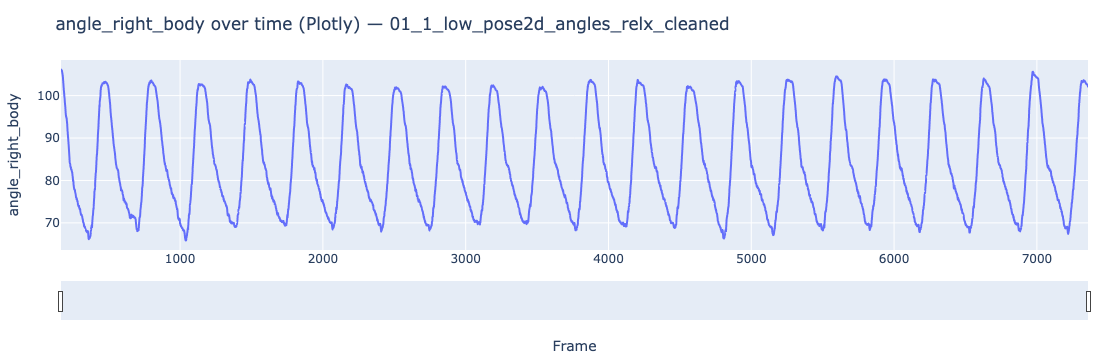

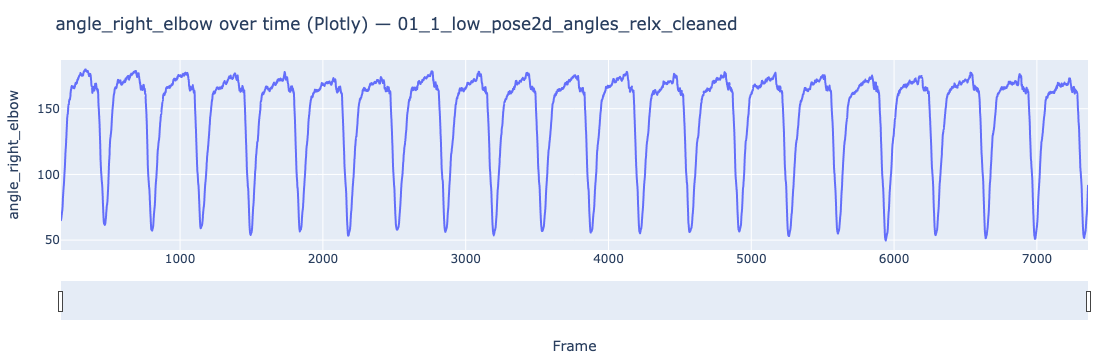

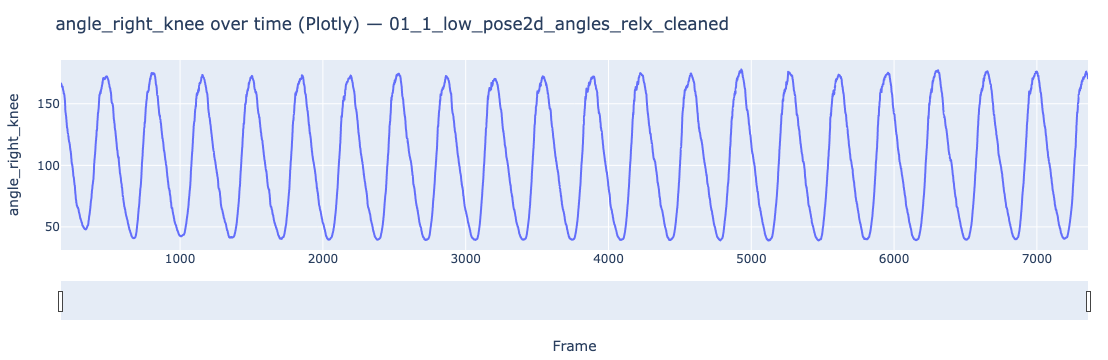

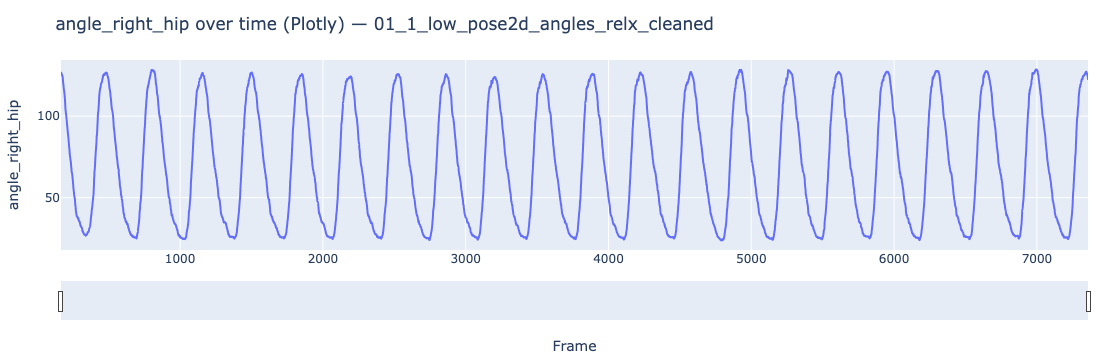

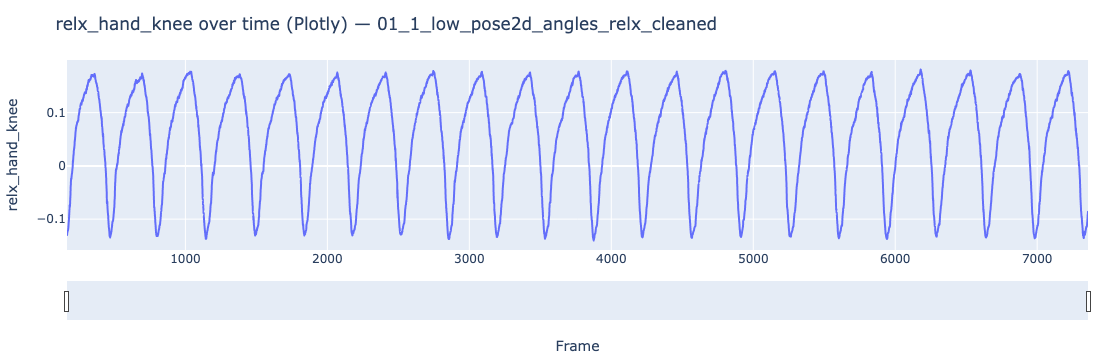

In [13]:
# ======================================================
# Plotting cleaned rowing data (angles & relative positions)
# Supports matplotlib / seaborn / plotly
# ======================================================

import pandas as pd
import numpy as np

# ---------- USER CONFIG ----------
INPUT_FILE = r"/Users/ameliaxu/Documents/ls100_project/MediaPipeEnv/outputs/angle_relx_cleaned/1_low/01_1_low_pose2d_angles_relx_cleaned.csv"
PLOT_BACKEND = "plotly"   # "matplotlib" | "seaborn" | "plotly"
VIDEO_NAME = None          # optional，can use the file name to generate title automatically
# ------------------------------------------------------

# --- Load cleaned data ---
df_plot = pd.read_csv(INPUT_FILE)
print(f"✅ Loaded {len(df_plot)} rows from {INPUT_FILE}")

# Try to infer "video" name if not in columns
if VIDEO_NAME is None:
    VIDEO_NAME = Path(INPUT_FILE).stem
title_suffix = f" — {VIDEO_NAME}"

# --- Validate columns ---
angle_cols = [c for c in df_plot.columns if c.startswith("angle_")]
relx_cols  = [c for c in df_plot.columns if c.startswith("relx_")]
conf_cols  = [c for c in df_plot.columns if c.startswith("confidence_")]

if not angle_cols and not relx_cols:
    raise ValueError("No 'angle_' or 'relx_' columns found in input file!")

print(f"📊 Found {len(angle_cols)} angle columns, {len(relx_cols)} relx columns, {len(conf_cols)} confidence columns")

# --- Helper: extract confidence spans for shading ---
def _spans_from_labels(frame_series, label_series, label_value):
    frames = frame_series.to_numpy()
    labels = (label_series.to_numpy() == label_value)
    spans = []
    start = None
    last_frame = None
    for f, ok in zip(frames, labels):
        if ok and start is None:
            start = f
        if ok:
            last_frame = f
        if (not ok) and (start is not None):
            spans.append((start, last_frame))
            start = None
    if start is not None:
        spans.append((start, last_frame))
    return spans

# --- Plotting backend selection ---
backend = PLOT_BACKEND.strip().lower()

if backend == "matplotlib":
    import matplotlib.pyplot as plt
    for col in angle_cols + relx_cols:
        conf_col = "confidence_" + col.split("_", 1)[1]
        plt.figure(figsize=(10, 4))
        plt.plot(df_plot["frame"], df_plot[col], label=col)
        plt.xlabel("Frame")
        plt.ylabel(col)
        plt.title(f"{col} over time (matplotlib){title_suffix}")
        ax = plt.gca()

        if conf_col in df_plot.columns:
            for x0, x1 in _spans_from_labels(df_plot["frame"], df_plot[conf_col], "low"):
                ax.axvspan(x0, x1, color="yellow", alpha=0.25, linewidth=0)
            for x0, x1 in _spans_from_labels(df_plot["frame"], df_plot[conf_col], "least"):
                ax.axvspan(x0, x1, color="orange", alpha=0.25, linewidth=0)

        plt.legend()
        plt.tight_layout()
        plt.show()

elif backend == "seaborn":
    import seaborn as sns
    import matplotlib.pyplot as plt
    for col in angle_cols + relx_cols:
        conf_col = "confidence_" + col.split("_", 1)[1]
        plt.figure(figsize=(10, 4))
        sns.lineplot(data=df_plot, x="frame", y=col)
        plt.xlabel("Frame")
        plt.ylabel(col)
        plt.title(f"{col} over time (seaborn){title_suffix}")
        ax = plt.gca()
        if conf_col in df_plot.columns:
            for x0, x1 in _spans_from_labels(df_plot["frame"], df_plot[conf_col], "low"):
                ax.axvspan(x0, x1, color="yellow", alpha=0.25, linewidth=0)
            for x0, x1 in _spans_from_labels(df_plot["frame"], df_plot[conf_col], "least"):
                ax.axvspan(x0, x1, color="orange", alpha=0.25, linewidth=0)
        plt.tight_layout()
        plt.show()

elif backend == "plotly":
    import plotly.express as px
    import plotly.graph_objects as go
    for col in angle_cols + relx_cols:
        conf_col = "confidence_" + col.split("_", 1)[1]
        fig = px.line(df_plot, x="frame", y=col,
                      title=f"{col} over time (Plotly){title_suffix}",
                      labels={"frame": "Frame", col: col})
        # confidence shading
        if conf_col in df_plot.columns:
            for x0, x1 in _spans_from_labels(df_plot["frame"], df_plot[conf_col], "low"):
                fig.add_vrect(x0=x0, x1=x1, fillcolor="yellow", opacity=0.25, line_width=0)
            for x0, x1 in _spans_from_labels(df_plot["frame"], df_plot[conf_col], "least"):
                fig.add_vrect(x0=x0, x1=x1, fillcolor="orange", opacity=0.25, line_width=0)

        fig.update_layout(
            xaxis_rangeslider_visible=True,
            hovermode="x unified",
            margin=dict(l=40, r=20, t=60, b=40)
        )
        fig.show()
else:
    raise ValueError("Unknown plot backend. Choose 'matplotlib', 'seaborn', or 'plotly'.")

#### Overlap Plot
Without the relative x-position

🎨 Plotting 3 angles: angle_right_body, angle_right_elbow, angle_right_knee
✅ Saved figure to: /Users/ameliaxu/Documents/ls100_project/MediaPipeEnv/outputs/plots/angles_overlay/04_2_low_angles_overlay.png


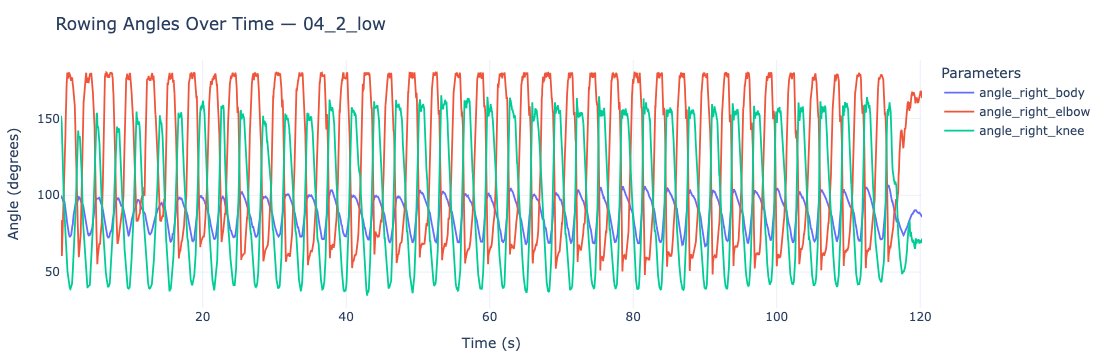

In [18]:
# =====================================================
# Overlay all angle_* (except hip) on a shared time axis
# =====================================================

import pandas as pd
import plotly.graph_objects as go
from pathlib import Path
import re

# ---------- USER CONFIG ----------
FILE = Path(r"/Users/ameliaxu/Documents/ls100_project/MediaPipeEnv/outputs/angle_relx_cleaned/2_low/04_2_low_pose2d_angles_relx_cleaned.csv")
EXCLUDE = ["angle_right_hip"]   # exclude those columns when plotting
TIME_COL = "time_ms"            
SAVE_DIR = Path(r"/Users/ameliaxu/Documents/ls100_project/MediaPipeEnv/outputs/plots/angles_overlay")  # <== folder where save the files
SAVE_DIR.mkdir(parents=True, exist_ok=True)
# ---------- Extract file ID ----------
# e.g. "04_1_low_pose2d_angles_relx_cleaned_60s.csv" → "04_1_low"
file_id = "_".join(FILE.stem.split("_")[:3])
# 或用正则：
# import re
# match = re.search(r"(\d+_\d+_(?:low|fast))", FILE.name)
# file_id = match.group(1) if match else FILE.stem

TITLE = f"Rowing Angles Over Time — {file_id}"
# ------------------------------------------------------

# ---------- Load data ----------
df = pd.read_csv(FILE)
if TIME_COL not in df.columns:
    raise ValueError("❌ 'time_ms' column not found — can't plot over time.")

# Convert ms → seconds
df["time_s"] = df[TIME_COL] / 1000.0

# Select all angle_* columns except excluded
angle_cols = [c for c in df.columns if c.startswith("angle_") and c not in EXCLUDE]
if not angle_cols:
    raise ValueError("❌ No valid angle_* columns found after exclusion.")

print(f"🎨 Plotting {len(angle_cols)} angles:", ", ".join(angle_cols))

# ---------- Plot with Plotly ----------
fig = go.Figure()
for col in angle_cols:
    fig.add_trace(go.Scatter(
        x=df["time_s"],
        y=df[col],
        mode="lines",
        name=col,
        line=dict(width=1.8)
    ))

fig.update_layout(
    title=TITLE,
    xaxis_title="Time (s)",
    yaxis_title="Angle (degrees)",
    hovermode="x unified",
    template="plotly_white",
    legend=dict(title="Parameters", bgcolor="rgba(255,255,255,0.6)"),
    margin=dict(l=50, r=20, t=60, b=40)
)

# ---------- Save to file ----------
out_path = SAVE_DIR / f"{file_id}_angles_overlay.png"
fig.write_image(out_path, scale=2, width=1200, height=600)
print(f"✅ Saved figure to: {out_path.resolve()}")

fig.show()

with the relative x-position

🎨 Plotting 3 angle columns and 1 relx columns.
✅ Saved dual-axis figure to: /Users/ameliaxu/Documents/ls100_project/MediaPipeEnv/outputs/plots/angles_overlay/01_1_fast_angles_relx_dualaxis.png


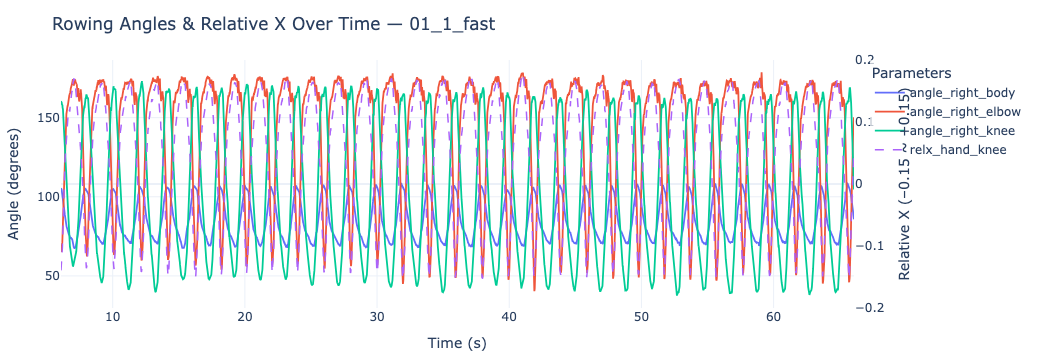

In [15]:
# =====================================================
# Overlay angle_* (except hip) + relx_* with dual y-axes
# =====================================================

import pandas as pd
import plotly.graph_objects as go
from pathlib import Path
import re

# ---------- USER CONFIG ----------
FILE = Path(r"/Users/ameliaxu/Documents/ls100_project/MediaPipeEnv/outputs/angle_relx_cleaned/1_fast/01_1_fast_pose2d_angles_relx_cleaned.csv")
EXCLUDE_ANGLE = ["angle_right_hip"]   # exclude those columns when plotting
TIME_COL = "time_ms"
SAVE_DIR = Path(r"/Users/ameliaxu/Documents/ls100_project/MediaPipeEnv/outputs/plots/angles_overlay")
SAVE_DIR.mkdir(parents=True, exist_ok=True)
# ------------------------------------------------------

# ---------- Extract file ID ----------
match = re.search(r"(\d+_\d+_(?:low|fast))", FILE.name)
file_id = match.group(1) if match else "_".join(FILE.stem.split("_")[:3])
TITLE = f"Rowing Angles & Relative X Over Time — {file_id}"

# ---------- Load data ----------
df = pd.read_csv(FILE)
if TIME_COL not in df.columns:
    raise ValueError("❌ 'time_ms' column not found — can't plot over time.")
df["time_s"] = df[TIME_COL] / 1000.0

# ---------- Select columns ----------
angle_cols = [c for c in df.columns if c.startswith("angle_") and c not in EXCLUDE_ANGLE]
relx_cols  = [c for c in df.columns if c.startswith("relx_")]
if not angle_cols and not relx_cols:
    raise ValueError("❌ No valid angle_* or relx_* columns found.")

print(f"🎨 Plotting {len(angle_cols)} angle columns and {len(relx_cols)} relx columns.")

# ---------- Build figure ----------
fig = go.Figure()

# 1️⃣ angle_* → left axis (degrees)
for col in angle_cols:
    fig.add_trace(go.Scatter(
        x=df["time_s"],
        y=df[col],
        mode="lines",
        name=col,
        line=dict(width=1.8),
        yaxis="y1"  # 左轴
    ))

# 2️⃣ relx_* → right axis (relative position)
for col in relx_cols:
    fig.add_trace(go.Scatter(
        x=df["time_s"],
        y=df[col],
        mode="lines",
        name=col,
        line=dict(width=1.5, dash="dash"),
        yaxis="y2"  # right axis
    ))

# ---------- Layout ----------
fig.update_layout(
    title=TITLE,
    xaxis=dict(title="Time (s)"),
    yaxis=dict(
        title="Angle (degrees)",
        side="left",
        showgrid=True
    ),
    yaxis2=dict(
        title="Relative X (–0.15 ~ +0.15)",
        overlaying="y",
        side="right",
        showgrid=False,
        range=[-0.2, 0.2]
    ),
    hovermode="x unified",
    template="plotly_white",
    legend=dict(title="Parameters", bgcolor="rgba(255,255,255,0.7)"),
    margin=dict(l=60, r=60, t=60, b=40)
)

# ---------- Save ----------
out_path = SAVE_DIR / f"{file_id}_angles_relx_dualaxis.png"
fig.write_image(out_path, scale=2, width=1300, height=650)
print(f"✅ Saved dual-axis figure to: {out_path.resolve()}")

# ---------- Show ----------
fig.show()

In [48]:
# %pip install -U kaleido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9/9 [kaleido]5;237m━━━━ 8/9 [kaleido]
Note: you may need to restart the kernel to use updated packages.


## Conclusion

Congratulations! You’ve now completed a full **pose analysis workflow** in Python:

1. Extracted **2D body landmark data** from videos using MediaPipe (Notebook 1).  
2. Computed **joint angles** and derived **confidence metrics** based on landmark visibility.  
3. Visualized these angles interactively and in batches across multiple recordings.

### What You’ve Learned
- How pose landmarks are represented as normalized 2D coordinates.  
- How to calculate geometric angles (∠ABC) for any combination of body joints.  
- How to assess **data reliability** using a visibility-based confidence system (`good`, `low`, `least`).  
- How to produce meaningful visualizations and batch-process datasets efficiently.

### Next Steps
In the next notebook, we will:
- Derive **custom biomechanical indices** (e.g., symmetry or smoothness metrics).  
- Explore **statistical summaries** and comparisons across individuals or sessions.

> **Remember:** Confidence flags and visualization overlays are not just for aesthetics—  
> they teach you to interpret pose-estimation data critically, separating **signal** from **noise**.
